In [87]:
from datetime import datetime

import os
from pathlib import Path
import subprocess
import warnings
import re
import pickle
import pandas as pd
import functools

import jax
import jax.numpy as jnp

from src.config.core import Config
from src.config.sampler import Sampler
from src.config.data import DatasetType
import src.dataset as ds
from src.models.tabular import FCN
import src.training.utils as train_utils
import src.inference.utils as inf_utils
import src.visualization as viz
from src.config.data import Task
from src.inference.evaluation import evaluate_bde

from matplotlib import pyplot as plt
import numpy as np

from tqdm import tqdm

Chains 2 - Mean LPPD: 0.49 ± 0.02, Mean RMSE: 0.26 ± 0.00
Chains 4 - Mean LPPD: 0.53 ± 0.01, Mean RMSE: 0.25 ± 0.00
Chains 6 - Mean LPPD: 0.53 ± 0.02, Mean RMSE: 0.26 ± 0.00
Chains 8 - Mean LPPD: 0.53 ± 0.02, Mean RMSE: 0.25 ± 0.00
Chains 10 - Mean LPPD: 0.52 ± 0.02, Mean RMSE: 0.25 ± 0.01
Chains 12 - Mean LPPD: 0.52 ± 0.03, Mean RMSE: 0.25 ± 0.01


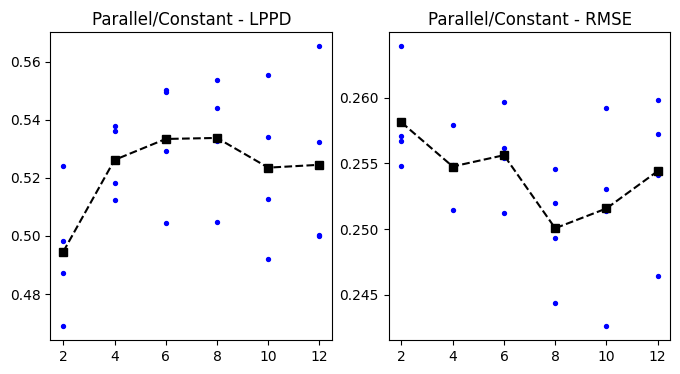

In [79]:
fig, axs = plt.subplots(figsize=(8, 4), ncols=2)
# discrete color map
cmap = plt.get_cmap('tab10')
def color_mapper(x):
    """Map integers to colors in the colormap."""
    return cmap(x % cmap.N)

mean_lppds_parallel = []
mean_rmses_parallel = []
std_lppds_parallel = []
std_rmses_parallel = []
mean_times_parallel = []
std_times_parallel = []
n_chains = np.array([2, 4, 6, 8, 10, 12])
seeds = [0, 1, 2, 3, 4]
for i, n in enumerate(n_chains):
    lppd = []
    rmse = []
    times = []
    for seed in seeds:
        if seed == 0:
            continue
        results_dir = f'results/bike2/parallel_constant_{n}_seed{seed}'
        with open(f'{results_dir}/eval_metrics.pkl', 'rb') as f:
            eval_metrics = pickle.load(f)
        with open(f'{results_dir}/samples/info.pkl', 'rb') as f:
            info = pickle.load(f)
        curr_lppd = eval_metrics['lppd']
        curr_rmse = eval_metrics['rmse']
        lppd.append(curr_lppd)
        rmse.append(curr_rmse)
        times.append(info['total_time'])
        axs[0].scatter(n, curr_lppd, s=8, color='blue')
        axs[1].scatter(n, curr_rmse, s=8, color='blue')

    mean_lppd = np.mean(lppd)
    std_lppd = np.std(lppd)
    mean_rmse = np.mean(rmse)
    std_rmse = np.std(rmse)
    mean_times = np.mean(times)
    std_times = np.std(times)
    print(f'Chains {n} - Mean LPPD: {mean_lppd:.2f} ± {std_lppd:.2f}, '
          f'Mean RMSE: {mean_rmse:.2f} ± {std_rmse:.2f}')
    mean_lppds_parallel.append(mean_lppd)
    mean_rmses_parallel.append(mean_rmse)
    std_lppds_parallel.append(std_lppd)
    std_rmses_parallel.append(std_rmse)
    mean_times_parallel.append(mean_times)
    std_times_parallel.append(std_times)

axs[0].plot(n_chains, mean_lppds_parallel, 's--', label='average over trials', color='black')
axs[1].plot(n_chains, mean_rmses_parallel, 's--', color='black')
axs[0].set_title('Parallel/Constant - LPPD')
axs[1].set_title('Parallel/Constant - RMSE')
# fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.15))
# plt.tight_layout()
plt.show()

Chains 2 - Mean LPPD: 0.47 ± 0.05, Mean RMSE: 0.26 ± 0.01
Chains 4 - Mean LPPD: 0.54 ± 0.04, Mean RMSE: 0.25 ± 0.01
Chains 6 - Mean LPPD: 0.59 ± 0.02, Mean RMSE: 0.24 ± 0.01
Chains 8 - Mean LPPD: 0.60 ± 0.02, Mean RMSE: 0.24 ± 0.01
Chains 10 - Mean LPPD: 0.61 ± 0.03, Mean RMSE: 0.24 ± 0.01
Chains 12 - Mean LPPD: 0.62 ± 0.03, Mean RMSE: 0.24 ± 0.01


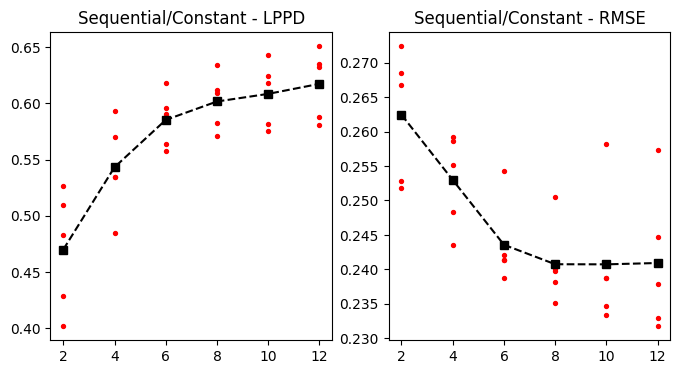

In [78]:
fig, axs = plt.subplots(figsize=(8, 4), ncols=2)
# discrete color map
cmap = plt.get_cmap('tab10')
def color_mapper(x):
    """Map integers to colors in the colormap."""
    return cmap(x % cmap.N)

mean_lppds_sequential = []
mean_rmses_sequential = []
std_lppds_sequential = []
std_rmses_sequential = []
mean_times_sequential = []
std_times_sequential = []
n_chains = [2, 4, 6, 8, 10, 12]
seeds = [0, 1, 2, 3, 4]
for i, n in enumerate(n_chains):
    lppd = []
    rmse = []
    times = []
    for seed in seeds:
        results_dir = f'results/bike0/sequential_constant_{n}_seed{seed}'
        with open(f'{results_dir}/eval_metrics.pkl', 'rb') as f:
            eval_metrics = pickle.load(f)
        with open(f'{results_dir}/samples/info.pkl', 'rb') as f:
            info = pickle.load(f)
        curr_lppd = eval_metrics['lppd']
        curr_rmse = eval_metrics['rmse']
        times.append(info['total_time'])
        lppd.append(curr_lppd)
        rmse.append(curr_rmse)
        axs[0].scatter(n, curr_lppd, s=8, color='red')
        axs[1].scatter(n, curr_rmse, s=8, color='red')

    mean_lppd = np.mean(lppd)
    std_lppd = np.std(lppd)
    mean_rmse = np.mean(rmse)
    std_rmse = np.std(rmse)
    mean_times = np.mean(times)
    std_times = np.std(times)
    print(f'Chains {n} - Mean LPPD: {mean_lppd:.2f} ± {std_lppd:.2f}, '
          f'Mean RMSE: {mean_rmse:.2f} ± {std_rmse:.2f}')
    mean_lppds_sequential.append(mean_lppd)
    mean_rmses_sequential.append(mean_rmse)
    std_lppds_sequential.append(std_lppd)
    std_rmses_sequential.append(std_rmse)
    mean_times_sequential.append(mean_times)
    std_times_sequential.append(std_times)

axs[0].plot(n_chains, mean_lppds_sequential, 's--', label='average over trials', color='black')
axs[1].plot(n_chains, mean_rmses_sequential, 's--', color='black')
axs[0].set_title('Sequential/Constant - LPPD')
axs[1].set_title('Sequential/Constant - RMSE')
# fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.15))
# plt.tight_layout()
plt.show()

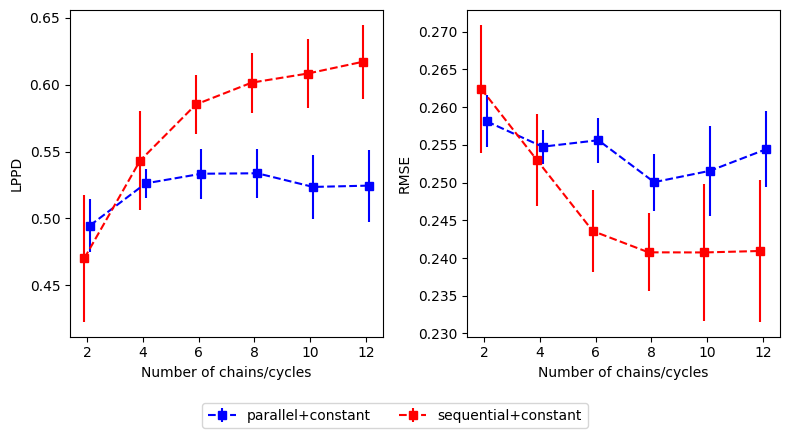

In [73]:
fig, axs = plt.subplots(figsize=(8, 4), ncols=2)
n_chains = np.asarray(n_chains)
axs[0].errorbar(n_chains+0.1, mean_lppds_parallel, yerr=std_lppds_parallel, fmt='s--', label='parallel+constant', color='blue')
axs[0].errorbar(n_chains-0.1, mean_lppds_sequential, yerr=std_lppds_sequential, fmt='s--', label='sequential+constant', color='red')
axs[0].set_ylabel('LPPD')
axs[0].set_xlabel('Number of chains/cycles')
axs[1].errorbar(n_chains+0.1, mean_rmses_parallel, yerr=std_rmses_parallel, fmt='s--', label='parallel+constant', color='blue')
axs[1].errorbar(n_chains-0.1, mean_rmses_sequential, yerr=std_rmses_sequential, fmt='s--', label='sequential+constant', color='red')
axs[1].set_ylabel('RMSE')
axs[1].set_xlabel('Number of chains/cycles')
# Remove duplicate labels in the legend
handles, labels = axs[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))
fig.tight_layout()

In [9]:
# How much does it improve over time in sequential?
results_dir = Path('results/bike0/sequential_constant_12_seed0')
tree_path = results_dir / 'tree'
n_cycles = 12
cycle_length = 500
samples = train_utils.load_samples_from_dir(results_dir / 'samples', tree_path=tree_path)

In [19]:
samples['fcn']['layer0']['kernel'][0, :500].shape

(500, 12, 16)

In [ ]:
cycle_length = 500
config = Config.from_yaml(results_dir / 'config.yaml')
module = config.get_flax_model()
loader = ds.TabularLoader(
    config.data,
    rng=config.jax_rng,
    target_len=config.data.target_len
)

features = loader.test_x # (B x F)
labels = loader.test_y # (B x T)
print("Test Set: Feature and Label have shapes: ", features.shape, labels.shape)

# mem_cap = 4 * 1024 ** 3 # 4 GB
# mem_usage = (
#     inf_utils.get_mem_size(samples) / 10
#     + inf_utils.get_mem_size(features)
#     + inf_utils.get_mem_size(labels)
# )
# overhead_unit = mem_usage * 10 # estimatation

# batch_size = max(1, (mem_cap - overhead_unit) // mem_usage)
# if batch_size > labels.shape[0]:
#     batch_size = None
# print(f'> Batch size for evaluation: {batch_size}\n')

all_metrics = []
for n in tqdm(range(1, n_cycles + 1)):
    curr_samples = jax.tree.map(
        lambda x: x[0, (n-1) * cycle_length : n * cycle_length][None, ...], samples
    )
    # print(curr_samples['fcn']['layer0']['kernel'].shape)
    metrics = {}
    logits, metrics = evaluate_bde(
        params=curr_samples,
        module=module,
        features=features,
        labels=labels,
        task=config.data.task,
        batch_size=None,
        verbose=False,
        metrics_dict=metrics,
        nominal_coverages=[0.5, 0.75, 0.9, 0.95],
        per_chain=False
    )
    all_metrics.append(metrics)

Test Set: Feature and Label have shapes:  (3476, 12) (3476,)


  8%|▊         | 1/12 [00:04<00:45,  4.11s/it]

Bayesian Deep Ensemble Performance | LPPD: 0.479, RMSE: 0.2712
__________________________________________________


 17%|█▋        | 2/12 [00:32<03:04, 18.44s/it]

Bayesian Deep Ensemble Performance | LPPD: 0.527, RMSE: 0.2608
__________________________________________________


 25%|██▌       | 3/12 [00:36<01:46, 11.79s/it]

Bayesian Deep Ensemble Performance | LPPD: 0.545, RMSE: 0.2503
__________________________________________________
Bayesian Deep Ensemble Performance | LPPD: 0.557, RMSE: 0.2448
__________________________________________________


 42%|████▏     | 5/12 [00:44<00:50,  7.28s/it]

Bayesian Deep Ensemble Performance | LPPD: 0.574, RMSE: 0.2428
__________________________________________________
Bayesian Deep Ensemble Performance | LPPD: 0.586, RMSE: 0.2404
__________________________________________________


 58%|█████▊    | 7/12 [00:51<00:28,  5.72s/it]

Bayesian Deep Ensemble Performance | LPPD: 0.584, RMSE: 0.2372
__________________________________________________
Bayesian Deep Ensemble Performance | LPPD: 0.590, RMSE: 0.2378
__________________________________________________


 75%|███████▌  | 9/12 [00:59<00:14,  4.98s/it]

Bayesian Deep Ensemble Performance | LPPD: 0.602, RMSE: 0.2319
__________________________________________________
Bayesian Deep Ensemble Performance | LPPD: 0.595, RMSE: 0.2313
__________________________________________________


 92%|█████████▏| 11/12 [01:06<00:04,  4.55s/it]

Bayesian Deep Ensemble Performance | LPPD: 0.590, RMSE: 0.2339
__________________________________________________


100%|██████████| 12/12 [00:45<00:00,  3.83s/it]

Bayesian Deep Ensemble Performance | LPPD: 0.602, RMSE: 0.2332
__________________________________________________


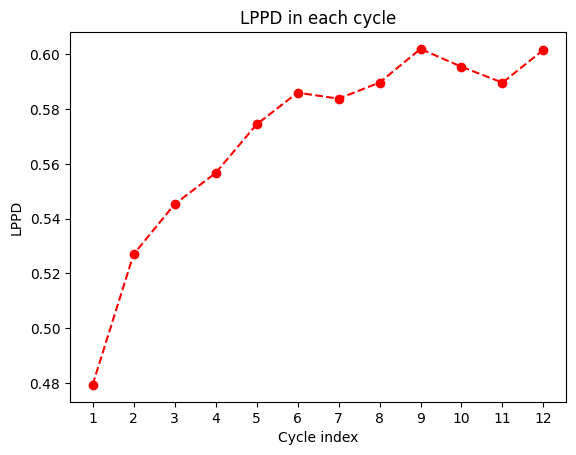

In [76]:
fig, ax = plt.subplots()
lppds = [all_metrics[i]['lppd'] for i in range(n_cycles)]
cycles = np.arange(n_cycles) + 1
ax.plot(cycles, lppds, 'o--', color='red')
ax.set_xticks(cycles)
ax.set_xlabel('Cycle index')
ax.set_ylabel("LPPD")
ax.set_title("LPPD in each cycle")
plt.show()

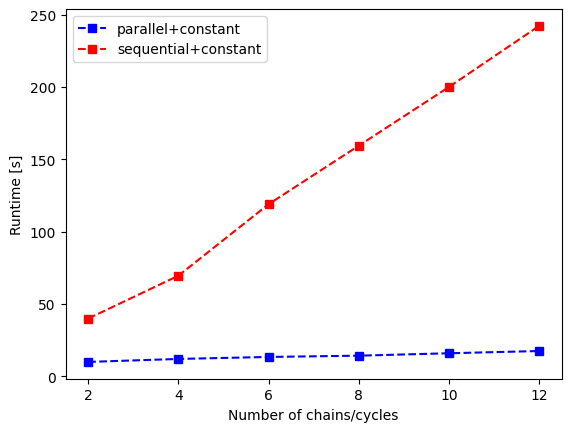

In [102]:
# runtime
fig, ax = plt.subplots()
ax.plot(n_chains, mean_times_parallel, 's--', label='parallel+constant', color='blue')
ax.plot(n_chains, mean_times_sequential, 's--', label='sequential+constant', color='red')
ax.set_ylabel('Runtime [s]')
ax.set_xlabel('Number of chains/cycles')
plt.legend(loc='upper left')